In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import keras
import tensorflow as tf
from keras.src.backend import l2_normalize
from tensorflow.keras import models, layers, Model

In [2]:
df = pd.read_csv("data/preprocessed_books.csv")

In [3]:
df_users = pd.read_csv("data/processed_users.csv")

In [4]:
df

,User-ID,ISBN,Book-Rating,title,author,rating,description,pages,awards,numRatings,...,Adult Fiction,Literature,Mystery Thriller,Crime,Audiobook,Historical,Adventure,Science Fiction,Young Adult,average_price
0,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,3.57,Little Altars Everywhere is a national best-se...,288,0,28611,...,1,0,0,0,0,1,0,0,0,3.39000
1,276747,0671537458,9,Waiting to Exhale,Terry McMillan,3.98,The story of friendship between four African A...,448,0,14718,...,1,0,0,0,0,0,0,0,0,0.89000
2,276747,0679776818,8,Birdsong: A Novel of Love and War,Sebastian Faulks,4.09,Published to international critical and popula...,483,1,68404,...,0,1,0,0,0,1,0,0,0,3.33000
3,276755,0451166892,5,The Pillars of the Earth,Ken Follett,4.31,Ken Follett is known worldwide as the master o...,976,0,648793,...,0,1,0,0,1,1,0,0,0,6.66651
4,276762,0380711524,5,See Jane Run,Joy Fielding,3.92,What do you do when you don't know who you are...,416,0,8008,...,1,0,1,1,0,0,0,0,0,2.86000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58532,276681,0060938455,9,Fast Food Nation: The Dark Side of the All-Ame...,Eric Schlosser,3.75,Fast food has hastened the malling of our land...,399,1,197560,...,0,0,0,0,0,0,0,0,0,3.09000
58533,276688,0553566040,6,Missing Joseph,Elizabeth George,3.96,Deborah and Simon St. James have taken a holid...,576,0,11641,...,0,1,1,1,0,0,0,0,0,7.51000
58534,276688,0553575104,6,In Pursuit of the Proper Sinner,Elizabeth George,4.10,A theatrical producer shoots himself on the ni...,718,0,12659,...,0,1,1,1,1,0,0,0,0,2.86000
58535,276688,0684804484,10,No Ordinary Time: Franklin and Eleanor Rooseve...,Doris Kearns Goodwin,4.18,"Winner of the Pulitzer for History, No Ordinar...",633,2,40982,...,0,0,0,0,0,1,0,0,0,7.08000


In [5]:
df_users

,User-ID,Location,Age,Country
0,1,"nyc, new york, usa",NaN,usa
1,2,"stockton, california, usa",18.0,usa
2,3,"moscow, yukon territory, russia",NaN,russia
3,4,"porto, v.n.gaia, portugal",17.0,portugal
4,5,"farnborough, hants, united kingdom",NaN,united kingdom
...,...,...,...,...
278853,278854,"portland, oregon, usa",NaN,usa
278854,278855,"tacoma, washington, united kingdom",50.0,united kingdom
278855,278856,"brampton, ontario, canada",NaN,canada
278856,278857,"knoxville, tennessee, usa",NaN,usa


Let's add the user data to the dataset:

In [6]:
df = df.merge(df_users[["User-ID", "Country", "Age"]], how="inner", left_on="User-ID", right_on="User-ID")

Reindex the ISBN and user ID data:

In [7]:
isbn_index_df = pd.DataFrame({"ISBN": df["ISBN"].unique(), "Index": range(len(df["ISBN"].unique()))})
df = df.merge(isbn_index_df, on="ISBN")
df = df.drop(columns="ISBN").rename(columns={"Index": "ISBN"})

user_index_df = pd.DataFrame({"User-ID": df["User-ID"].unique(), "Index": range(len(df["User-ID"].unique()))})
df = df.merge(user_index_df, on="User-ID")
df = df.drop(columns="User-ID").rename(columns={"Index": "User-ID"})

In [8]:
df

,Book-Rating,title,author,rating,description,pages,awards,numRatings,likedPercent,bbeScore,...,Audiobook,Historical,Adventure,Science Fiction,Young Adult,average_price,Country,Age,ISBN,User-ID
0,9,Little Altars Everywhere,Rebecca Wells,3.57,Little Altars Everywhere is a national best-se...,288,0,28611,88.0,476,...,0,1,0,0,0,3.39,usa,25.0,0,0
1,9,Waiting to Exhale,Terry McMillan,3.98,The story of friendship between four African A...,448,0,14718,94.0,95,...,0,0,0,0,0,0.89,usa,25.0,1,0
2,8,Birdsong: A Novel of Love and War,Sebastian Faulks,4.09,Published to international critical and popula...,483,1,68404,93.0,6741,...,0,1,0,0,0,3.33,usa,25.0,2,0
3,7,Little Altars Everywhere,Rebecca Wells,3.57,Little Altars Everywhere is a national best-se...,288,0,28611,88.0,476,...,0,1,0,0,0,3.39,usa,28.0,0,1
4,9,The Bonesetter's Daughter,Amy Tan,3.98,"Ruth Young and her widowed mother, LuLing, hav...",387,2,121064,96.0,1629,...,0,1,0,0,0,3.16,usa,28.0,217,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58532,1,Pandora,Anne Rice,3.76,"Anne Rice, creator of the Vampire Lestat, the ...",383,0,41401,89.0,2010,...,0,1,0,0,0,1.67,spain,22.0,7297,22534
58533,9,Grumbles from the Grave,"Robert A. Heinlein, Virginia Heinlein (Editor)",3.59,"Long before his death in 1988, Robert A. Heinl...",281,2,2142,88.0,259,...,1,0,0,1,0,3.15,usa,NaN,7304,22535
58534,6,The Iliad,"Homer, Robert Fagles (Translator), Bernard Kno...",3.87,"Dating to the ninth century B.C., Homer’s time...",683,0,352181,90.0,7420,...,0,1,0,0,0,5.49,usa,28.0,7305,22536
58535,7,The Moon Riders,Theresa Tomlinson,3.87,Myrina has prepared for thirteen years to join...,381,0,562,88.0,69,...,0,1,1,0,1,3.46,united kingdom,60.0,7306,22537


Let's fill the missing age data:

In [9]:
df["Age"] = df["Age"].fillna(df["Age"].median())

# Rating Creation

We want to combine all rating, award and score information into one metric, so we can evaluate and compare books against each other as accurately as possible.

Let's make the bbeVotes a relative score:

In [10]:
def standardize(series): 
    return 100 * (series - series.min()) / series.max()

In [11]:
df["bbePopularity"] = np.ceil(standardize(df["bbeVotes"]))
df["bbePopularity"]

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
58532    1.0
58533    1.0
58534    1.0
58535    1.0
58536    1.0
Name: bbePopularity, Length: 58537, dtype: float64

Let's transform the rating into percentage:

In [12]:
df["rating"] = standardize(df["rating"] * 100 / 5)
df["rating"]

0        23.6
1        31.8
2        34.0
3        23.6
4        31.8
         ... 
58532    27.4
58533    24.0
58534    29.6
58535    29.6
58536    24.4
Name: rating, Length: 58537, dtype: float64

In [13]:
df["awards"].value_counts()

awards
0     33601
1     11271
2      5454
3      2044
4      1883
5      1374
9       604
6       589
8       539
7       374
13      317
10      156
11      134
12       93
22       47
15       42
16        6
17        3
25        2
14        2
21        1
28        1
Name: count, dtype: int64

We can transform the values into ordinal categories:

In [14]:
bins = [0, 0.99, 4.99, 9.99, 29.99]

labels = [15, 60, 85, 100]

df["awards"] = pd.cut(df["awards"], bins=bins, labels=labels, right=False).astype(int)

In [15]:
df["awards"].value_counts()

awards
15     33601
60     20652
85      3480
100      804
Name: count, dtype: int64

We will evaluate the books (in percentage) based on the following formula:

- 30% - liked percentage
- 35% - rating
- 15% - BBE popularity
- 20% - awards

In [16]:
df["overall_rating"] = standardize(df["likedPercent"] * 30 + df["rating"] * 35 + df["bbePopularity"] * 15 + df["awards"] * 20)

[]

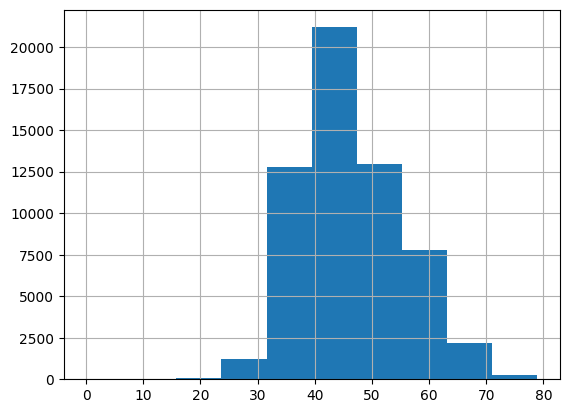

In [17]:
df["overall_rating"].hist()
plt.plot()

Let's see which are the best books according to the new metric:

In [18]:
book_df = df.copy()
book_df = book_df.drop(columns=["User-ID", "Book-Rating", "Age", "Country"])
book_df.drop_duplicates(inplace=True)
book_df.reset_index(inplace=True, drop=True)

In [19]:
book_df

,title,author,rating,description,pages,awards,numRatings,likedPercent,bbeScore,bbeVotes,...,Crime,Audiobook,Historical,Adventure,Science Fiction,Young Adult,average_price,ISBN,bbePopularity,overall_rating
0,Little Altars Everywhere,Rebecca Wells,23.6,Little Altars Everywhere is a national best-se...,288,15,28611,88.0,476,8,...,0,0,1,0,0,0,3.39,0,1.0,33.768873
1,Waiting to Exhale,Terry McMillan,31.8,The story of friendship between four African A...,448,15,14718,94.0,95,1,...,0,0,0,0,0,0,0.89,1,1.0,40.548780
2,Birdsong: A Novel of Love and War,Sebastian Faulks,34.0,Published to international critical and popula...,483,60,68404,93.0,6741,90,...,0,0,1,0,0,0,3.33,2,1.0,54.297329
3,The Bonesetter's Daughter,Amy Tan,31.8,"Ruth Young and her widowed mother, LuLing, hav...",387,60,121064,96.0,1629,21,...,0,0,1,0,0,0,3.16,217,1.0,54.486063
4,The Things They Carried,Tim O'Brien,34.8,"In 1979, Tim O'Brien's Going After Cacciato—a ...",246,60,253046,94.0,42780,523,...,0,0,1,0,0,0,3.32,252,3.0,55.574913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7613,Pandora,Anne Rice,27.4,"Anne Rice, creator of the Vampire Lestat, the ...",383,15,41401,89.0,2010,30,...,0,0,1,0,0,0,1.67,7297,1.0,36.135308
7614,Grumbles from the Grave,"Robert A. Heinlein, Virginia Heinlein (Editor)",24.0,"Long before his death in 1988, Robert A. Heinl...",281,60,2142,88.0,259,3,...,0,1,0,0,1,0,3.15,7304,1.0,47.038328
7615,The Iliad,"Homer, Robert Fagles (Translator), Bernard Kno...",29.6,"Dating to the ninth century B.C., Homer’s time...",683,15,352181,90.0,7420,100,...,0,0,1,0,0,0,5.49,7305,1.0,37.688734
7616,The Moon Riders,Theresa Tomlinson,29.6,Myrina has prepared for thirteen years to join...,381,15,562,88.0,69,1,...,0,0,1,1,0,1,3.46,7306,1.0,36.817654


[]

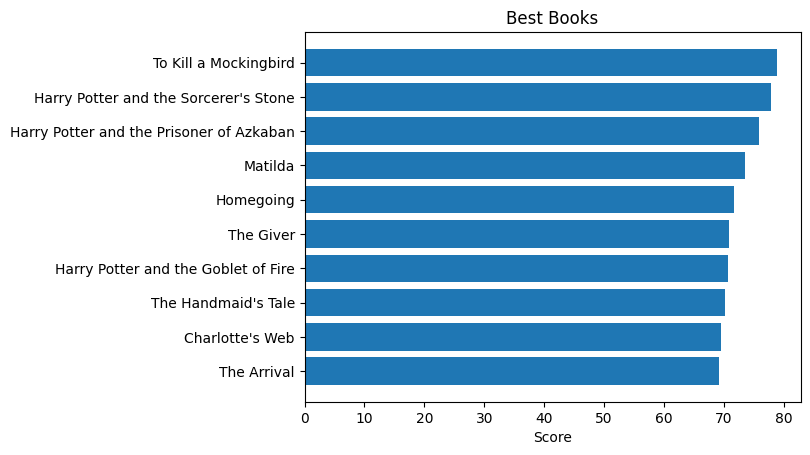

In [20]:
plt.barh(
    book_df.sort_values("overall_rating", ascending=False)["title"].head(10),
    book_df.sort_values("overall_rating", ascending=False)["overall_rating"].head(10), 
    align="center"
)
plt.gca().invert_yaxis()
plt.xlabel("Score")
plt.title("Best Books")
plt.plot()

# Content Based Filtering

## TF-IDF

In [21]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=30_000, dtype=np.float32)
book_df["description"] = book_df["description"].fillna("")
tfidf_matrix = tfidf_vectorizer.fit_transform(book_df["description"])
tfidf_matrix.shape

(7618, 30000)

In [22]:
title_to_index = pd.Series(book_df.index, index=book_df["title"]).drop_duplicates()

In [23]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [24]:
def get_recommendations(title, similarity):
    idx = title_to_index[title]
    sim_scores = list(enumerate(similarity[idx]))
    sim_scores.sort(key=lambda X: X[1], reverse=True)
    sim_scores = sim_scores[1:11]
    indices = [i[0] for i in sim_scores]
    return book_df["title"].iloc[indices]

In [25]:
get_recommendations("Harry Potter and the Prisoner of Azkaban", cosine_sim)

1555              Harry Potter and the Chamber of Secrets
7208                Harry Potter and the Sorcerer's Stone
5521                  Harry Potter and the Goblet of Fire
2853    Harry Potter Schoolbooks Box Set: Two Classic ...
2162                                               Pronto
6932                                    Star in the Storm
5965                                        Into the Blue
1152              Fantastic Beasts and Where to Find Them
1137                                          Blood Rites
5385                               Absolutely, Positively
Name: title, dtype: object

## Count Vectorizer

In [26]:
genres = ["Fiction", "Novels", "Adult", "Mystery", "Contemporary", "Thriller", "Romance",
          "Classics", "Suspense", "Fantasy", "Historical Fiction", "Adult Fiction", "Literature", "Mystery Thriller",
          "Crime", "Audiobook", "Historical", "Adventure", "Science Fiction", "Young Adult"]

In [27]:
def get_genres(row):
    current_genres = ""
    for genre in genres:
        if row[genre] == 1:
            current_genres += genre + ", "
    return current_genres

In [28]:
def get_characteristics(x):
    return get_genres(x) + x["author"] + x["description"]

book_df["combined_characteristics"] = book_df.apply(get_characteristics, axis=1)

In [29]:
book_df

,title,author,rating,description,pages,awards,numRatings,likedPercent,bbeScore,bbeVotes,...,Audiobook,Historical,Adventure,Science Fiction,Young Adult,average_price,ISBN,bbePopularity,overall_rating,combined_characteristics
0,Little Altars Everywhere,Rebecca Wells,23.6,Little Altars Everywhere is a national best-se...,288,15,28611,88.0,476,8,...,0,1,0,0,0,3.39,0,1.0,33.768873,"Fiction, Novels, Adult, Contemporary, Historic..."
1,Waiting to Exhale,Terry McMillan,31.8,The story of friendship between four African A...,448,15,14718,94.0,95,1,...,0,0,0,0,0,0.89,1,1.0,40.548780,"Fiction, Novels, Adult, Contemporary, Romance,..."
2,Birdsong: A Novel of Love and War,Sebastian Faulks,34.0,Published to international critical and popula...,483,60,68404,93.0,6741,90,...,0,1,0,0,0,3.33,2,1.0,54.297329,"Fiction, Novels, Romance, Classics, Historical..."
3,The Bonesetter's Daughter,Amy Tan,31.8,"Ruth Young and her widowed mother, LuLing, hav...",387,60,121064,96.0,1629,21,...,0,1,0,0,0,3.16,217,1.0,54.486063,"Fiction, Novels, Adult, Contemporary, Historic..."
4,The Things They Carried,Tim O'Brien,34.8,"In 1979, Tim O'Brien's Going After Cacciato—a ...",246,60,253046,94.0,42780,523,...,0,1,0,0,0,3.32,252,3.0,55.574913,"Fiction, Classics, Historical Fiction, Literat..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7613,Pandora,Anne Rice,27.4,"Anne Rice, creator of the Vampire Lestat, the ...",383,15,41401,89.0,2010,30,...,0,1,0,0,0,1.67,7297,1.0,36.135308,"Fiction, Fantasy, Historical Fiction, Historic..."
7614,Grumbles from the Grave,"Robert A. Heinlein, Virginia Heinlein (Editor)",24.0,"Long before his death in 1988, Robert A. Heinl...",281,60,2142,88.0,259,3,...,1,0,0,1,0,3.15,7304,1.0,47.038328,"Fiction, Fantasy, Audiobook, Science Fiction, ..."
7615,The Iliad,"Homer, Robert Fagles (Translator), Bernard Kno...",29.6,"Dating to the ninth century B.C., Homer’s time...",683,15,352181,90.0,7420,100,...,0,1,0,0,0,5.49,7305,1.0,37.688734,"Fiction, Classics, Fantasy, Historical Fiction..."
7616,The Moon Riders,Theresa Tomlinson,29.6,Myrina has prepared for thirteen years to join...,381,15,562,88.0,69,1,...,0,1,1,0,1,3.46,7306,1.0,36.817654,"Fiction, Adult, Romance, Fantasy, Historical F..."


In [30]:
count_vectorizer = CountVectorizer(stop_words="english")
count_matrix = count_vectorizer.fit_transform(book_df["combined_characteristics"])

In [31]:
count_sim = linear_kernel(count_matrix, count_matrix)

In [32]:
get_recommendations("Harry Potter and the Prisoner of Azkaban", count_sim)

7208                Harry Potter and the Sorcerer's Stone
1555              Harry Potter and the Chamber of Secrets
2853    Harry Potter Schoolbooks Box Set: Two Classic ...
2008                                          The Bottoms
7608    Leadership and the New Science: Discovering Or...
4169                                             Still Me
5521                  Harry Potter and the Goblet of Fire
2162                                               Pronto
7343                         The Complete Sherlock Holmes
1152              Fantastic Beasts and Where to Find Them
Name: title, dtype: object

## Neural Network Approach 

In [33]:
contentb_df = df.copy()

In [34]:
contentb_df = pd.get_dummies(contentb_df, columns=["Country"], dtype=np.int64)

In [35]:
contentb_df

,Book-Rating,title,author,rating,description,pages,awards,numRatings,likedPercent,bbeScore,...,Country_slovenia,Country_south africa,Country_south korea,Country_spain,Country_sweden,Country_switzerland,Country_taiwan,Country_turkey,Country_united kingdom,Country_usa
0,9,Little Altars Everywhere,Rebecca Wells,23.6,Little Altars Everywhere is a national best-se...,288,15,28611,88.0,476,...,0,0,0,0,0,0,0,0,0,1
1,9,Waiting to Exhale,Terry McMillan,31.8,The story of friendship between four African A...,448,15,14718,94.0,95,...,0,0,0,0,0,0,0,0,0,1
2,8,Birdsong: A Novel of Love and War,Sebastian Faulks,34.0,Published to international critical and popula...,483,60,68404,93.0,6741,...,0,0,0,0,0,0,0,0,0,1
3,7,Little Altars Everywhere,Rebecca Wells,23.6,Little Altars Everywhere is a national best-se...,288,15,28611,88.0,476,...,0,0,0,0,0,0,0,0,0,1
4,9,The Bonesetter's Daughter,Amy Tan,31.8,"Ruth Young and her widowed mother, LuLing, hav...",387,60,121064,96.0,1629,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58532,1,Pandora,Anne Rice,27.4,"Anne Rice, creator of the Vampire Lestat, the ...",383,15,41401,89.0,2010,...,0,0,0,1,0,0,0,0,0,0
58533,9,Grumbles from the Grave,"Robert A. Heinlein, Virginia Heinlein (Editor)",24.0,"Long before his death in 1988, Robert A. Heinl...",281,60,2142,88.0,259,...,0,0,0,0,0,0,0,0,0,1
58534,6,The Iliad,"Homer, Robert Fagles (Translator), Bernard Kno...",29.6,"Dating to the ninth century B.C., Homer’s time...",683,15,352181,90.0,7420,...,0,0,0,0,0,0,0,0,0,1
58535,7,The Moon Riders,Theresa Tomlinson,29.6,Myrina has prepared for thirteen years to join...,381,15,562,88.0,69,...,0,0,0,0,0,0,0,0,1,0


In [36]:
user_feature_columns = ["Age"] + [x for x in contentb_df.columns if "Country_" in x]

In [37]:
book_feature_columns = ["pages", "Year-Of-Publication", "average_price", "overall_rating"] + genres

In [38]:
scaler = StandardScaler()
scaler.fit(contentb_df[user_feature_columns])
contentb_df[user_feature_columns] = scaler.transform(contentb_df[user_feature_columns])

scaler = StandardScaler()
scaler.fit(contentb_df[book_feature_columns])
contentb_df[book_feature_columns] = scaler.transform(contentb_df[book_feature_columns])

In [39]:
contentb_df.dropna(inplace=True)

In [40]:
contentb_df

,Book-Rating,title,author,rating,description,pages,awards,numRatings,likedPercent,bbeScore,...,Country_slovenia,Country_south africa,Country_south korea,Country_spain,Country_sweden,Country_switzerland,Country_taiwan,Country_turkey,Country_united kingdom,Country_usa
0,9,Little Altars Everywhere,Rebecca Wells,23.6,Little Altars Everywhere is a national best-se...,-0.522925,15,28611,88.0,476,...,-0.011691,-0.010936,-0.011691,-0.086827,-0.032562,-0.032298,-0.009242,-0.010125,-0.170574,0.580526
1,9,Waiting to Exhale,Terry McMillan,31.8,The story of friendship between four African A...,0.409136,15,14718,94.0,95,...,-0.011691,-0.010936,-0.011691,-0.086827,-0.032562,-0.032298,-0.009242,-0.010125,-0.170574,0.580526
2,8,Birdsong: A Novel of Love and War,Sebastian Faulks,34.0,Published to international critical and popula...,0.613025,60,68404,93.0,6741,...,-0.011691,-0.010936,-0.011691,-0.086827,-0.032562,-0.032298,-0.009242,-0.010125,-0.170574,0.580526
3,7,Little Altars Everywhere,Rebecca Wells,23.6,Little Altars Everywhere is a national best-se...,-0.522925,15,28611,88.0,476,...,-0.011691,-0.010936,-0.011691,-0.086827,-0.032562,-0.032298,-0.009242,-0.010125,-0.170574,0.580526
4,9,The Bonesetter's Daughter,Amy Tan,31.8,"Ruth Young and her widowed mother, LuLing, hav...",0.053788,60,121064,96.0,1629,...,-0.011691,-0.010936,-0.011691,-0.086827,-0.032562,-0.032298,-0.009242,-0.010125,-0.170574,0.580526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58532,1,Pandora,Anne Rice,27.4,"Anne Rice, creator of the Vampire Lestat, the ...",0.030486,15,41401,89.0,2010,...,-0.011691,-0.010936,-0.011691,11.517210,-0.032562,-0.032298,-0.009242,-0.010125,-0.170574,-1.722575
58533,9,Grumbles from the Grave,"Robert A. Heinlein, Virginia Heinlein (Editor)",24.0,"Long before his death in 1988, Robert A. Heinl...",-0.563703,60,2142,88.0,259,...,-0.011691,-0.010936,-0.011691,-0.086827,-0.032562,-0.032298,-0.009242,-0.010125,-0.170574,0.580526
58534,6,The Iliad,"Homer, Robert Fagles (Translator), Bernard Kno...",29.6,"Dating to the ninth century B.C., Homer’s time...",1.778102,15,352181,90.0,7420,...,-0.011691,-0.010936,-0.011691,-0.086827,-0.032562,-0.032298,-0.009242,-0.010125,-0.170574,0.580526
58535,7,The Moon Riders,Theresa Tomlinson,29.6,Myrina has prepared for thirteen years to join...,0.018836,15,562,88.0,69,...,-0.011691,-0.010936,-0.011691,-0.086827,-0.032562,-0.032298,-0.009242,-0.010125,5.862575,-1.722575


In [41]:
contentb_df["Book-Rating"] /= 10

In [42]:
train, test = train_test_split(contentb_df, train_size=0.8, shuffle=True, random_state=1)

In [43]:
user_NN = models.Sequential([
    layers.Dense(512, activation="leaky_relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(64, activation='linear'),
])

item_NN = models.Sequential([
    layers.Dense(4096, activation="leaky_relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(64, activation="linear"), 
])

user_input = layers.Input(shape=(len(user_feature_columns)))
user_net = user_NN(user_input)
user_net = tf.math.l2_normalize(user_net, axis=1)

book_input = layers.Input(shape=(len(book_feature_columns)))
book_net = item_NN(book_input)
book_net = l2_normalize(book_net, axis=1)

output = layers.Dot(axes=1)([user_net, book_net])

model = Model([user_input, book_input], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 47)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 24)]                 0         []                            
                                                                                                  
 sequential (Sequential)     (None, 64)                   172352    ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64)                   2232896   ['input_2[0][0]']             
                                                                                              

In [44]:
loss = keras.losses.MeanAbsoluteError()
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(
    optimizer=optimizer,
    loss=loss
)

In [45]:
history = model.fit(
    [train[user_feature_columns], train[book_feature_columns]], 
    train["Book-Rating"], 
    epochs=10, 
    verbose=1,
    validation_split=0.1
)

Epoch 1/10
1313/1313 [==============================] - 15s 11ms/step - loss: 0.1525 - val_loss: 0.1326
Epoch 2/10
1313/1313 [==============================] - 15s 11ms/step - loss: 0.1352 - val_loss: 0.1325
Epoch 3/10
1313/1313 [==============================] - 16s 12ms/step - loss: 0.1341 - val_loss: 0.1318
Epoch 4/10
1313/1313 [==============================] - 17s 13ms/step - loss: 0.1334 - val_loss: 0.1316
Epoch 5/10
1313/1313 [==============================] - 17s 13ms/step - loss: 0.1327 - val_loss: 0.1312
Epoch 6/10
1313/1313 [==============================] - 17s 13ms/step - loss: 0.1321 - val_loss: 0.1313
Epoch 7/10
1313/1313 [==============================] - 17s 13ms/step - loss: 0.1315 - val_loss: 0.1314
Epoch 8/10
1313/1313 [==============================] - 17s 13ms/step - loss: 0.1312 - val_loss: 0.1319
Epoch 9/10
1313/1313 [==============================] - 17s 13ms/step - loss: 0.1307 - val_loss: 0.1321
Epoch 10/10
1313/1313 [==============================] - 17s 13m

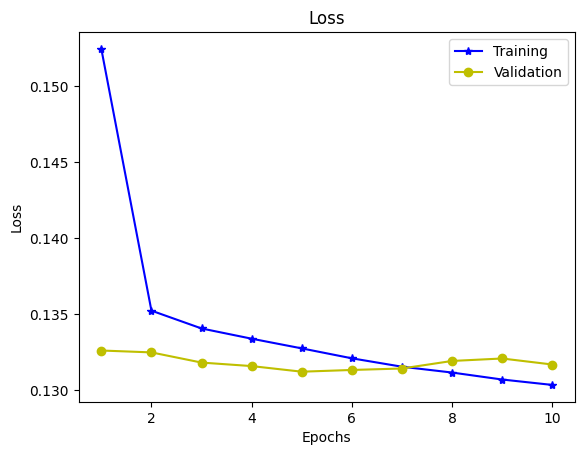

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b*-', label='Training')
plt.plot(epochs, val_loss, 'yo-', label='Validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
model.evaluate([test[user_feature_columns], test[book_feature_columns]], test["Book-Rating"])

365/365 [==============================] - 1s 2ms/step - loss: 0.1359


0.13586056232452393

In [48]:
def get_user_book_score(user, book):
    user = user.astype(np.float32).values
    book = book.astype(np.float32).values
    
    user_features = user.reshape(1, -1)
    book_features = book.reshape(1, -1)
    
    user_features_tensor = tf.convert_to_tensor(user_features)
    book_features_tensor = tf.convert_to_tensor(book_features)
    
    return model.predict([user_features_tensor, book_features_tensor])

In [49]:
get_user_book_score(test.iloc[5][user_feature_columns], test.iloc[5][book_feature_columns])

1/1 [==============================] - 0s 65ms/step


array([[0.81886286]], dtype=float32)

In [50]:
test.iloc[5]

Book-Rating                                                             0.8
title                                                              Betrayed
author                                            P.C. Cast , Kristin Cast 
rating                                                                 30.8
description               Also see: Alternate Cover Editions for this IS...
                                                ...                        
Country_switzerland                                               -0.032298
Country_taiwan                                                    -0.009242
Country_turkey                                                    -0.010125
Country_united kingdom                                            -0.170574
Country_usa                                                        0.580526
Name: 6100, Length: 84, dtype: object

In [51]:
def recommend_books(user, n, remove_read=True):
    def calculate_score(row):
        return get_user_book_score(user[user_feature_columns], row[book_feature_columns])[0][0]
    
    book_filter = ["title"] + book_feature_columns  + ["ISBN"]
    all_books = contentb_df[book_filter].drop_duplicates()
    
    if remove_read:
        read_books = contentb_df[contentb_df["User-ID"] == user["User-ID"]]
        read_ids = read_books["ISBN"].tolist()
        all_books = all_books[~all_books["ISBN"].isin(read_ids)]
    
    all_books['score'] = all_books.apply(calculate_score, axis=1)
    return all_books.sort_values(by='score', ascending=False).iloc[:n]["title"]

In [80]:
test.iloc[30][user_feature_columns]

KeyError: "None of [Index(['Age', 'Country_argentina', 'Country_australia', 'Country_austria',\n       'Country_belgium', 'Country_brazil', 'Country_canada', 'Country_chile',\n       'Country_china', 'Country_costa rica', 'Country_czech republic',\n       'Country_denmark', 'Country_finland', 'Country_france',\n       'Country_germany', 'Country_greece', 'Country_hong kong',\n       'Country_india', 'Country_iran', 'Country_ireland', 'Country_israel',\n       'Country_italy', 'Country_japan', 'Country_malaysia', 'Country_mexico',\n       'Country_netherlands', 'Country_new zealand', 'Country_norway',\n       'Country_other', 'Country_pakistan', 'Country_philippines',\n       'Country_poland', 'Country_portugal', 'Country_romania',\n       'Country_russia', 'Country_singapore', 'Country_slovakia',\n       'Country_slovenia', 'Country_south africa', 'Country_south korea',\n       'Country_spain', 'Country_sweden', 'Country_switzerland',\n       'Country_taiwan', 'Country_turkey', 'Country_united kingdom',\n       'Country_usa'],\n      dtype='object')] are in the [index]"

In [52]:
recs = recommend_books(test.iloc[30], n=5)

1/1 [==============================] - 0s 13ms/step


In [53]:
recs

1201                  The Little Prince
269                  The Cat in the Hat
6268      Little House in the Big Woods
814     The Sneetches and Other Stories
728                   The Napping House
Name: title, dtype: object

**Content based filtering conclusion**: The content based approach can predict if a user will like a book or not accurately. The average error of ≈1.3/10 is accurate enough for the purpose of giving recommendations. 

# Collaborative Filtering

In [54]:
BATCH_SIZE = 256
EMBEDDING_SIZE = 30
EPOCHS = 100

## Data Preparation

In [55]:
df.head()

,Book-Rating,title,author,rating,description,pages,awards,numRatings,likedPercent,bbeScore,...,Adventure,Science Fiction,Young Adult,average_price,Country,Age,ISBN,User-ID,bbePopularity,overall_rating
0,9,Little Altars Everywhere,Rebecca Wells,23.6,Little Altars Everywhere is a national best-se...,288,15,28611,88.0,476,...,0,0,0,3.39,usa,25.0,0,0,1.0,33.768873
1,9,Waiting to Exhale,Terry McMillan,31.8,The story of friendship between four African A...,448,15,14718,94.0,95,...,0,0,0,0.89,usa,25.0,1,0,1.0,40.548780
2,8,Birdsong: A Novel of Love and War,Sebastian Faulks,34.0,Published to international critical and popula...,483,60,68404,93.0,6741,...,0,0,0,3.33,usa,25.0,2,0,1.0,54.297329
3,7,Little Altars Everywhere,Rebecca Wells,23.6,Little Altars Everywhere is a national best-se...,288,15,28611,88.0,476,...,0,0,0,3.39,usa,28.0,0,1,1.0,33.768873
4,9,The Bonesetter's Daughter,Amy Tan,31.8,"Ruth Young and her widowed mother, LuLing, hav...",387,60,121064,96.0,1629,...,0,0,0,3.16,usa,28.0,217,1,1.0,54.486063


In [56]:
rating_df = df.pivot(index='User-ID', columns='ISBN', values='Book-Rating')

rating_df = pd.DataFrame.sparse.from_spmatrix(
    csr_matrix(rating_df.values), 
    index=rating_df.index, 
    columns=rating_df.columns
)

rating_df

ISBN,0,1,2,3,4,5,6,7,8,9,...,7308,7309,7310,7311,7312,7313,7314,7315,7316,7317
User-ID,,,,,,,,,,,,,,,,,,,,,
0,9.0,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
rating_df = pd.DataFrame(
    preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(rating_df.values), 
    columns=rating_df.columns, 
    index=rating_df.index
)

rating_df

ISBN,0,1,2,3,4,5,6,7,8,9,...,7308,7309,7310,7311,7312,7313,7314,7315,7316,7317
User-ID,,,,,,,,,,,,,,,,,,,,,
0,0.9,1.0,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
num_users = rating_df.shape[0]
num_users

22539

In [59]:
num_books = rating_df.shape[1]
num_books

7318

In [60]:
split = int(0.8 * rating_df.shape[1])
dtf_train = rating_df.loc[:, :split-1]
dtf_test = rating_df.loc[:, split:]

train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"rating"})
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"rating"})

In [61]:
train

,User-ID,ISBN,rating
0,0,0,0.900000
1,0,1,1.000000
2,0,2,0.800000
3,1,0,0.700000
4,1,217,0.928571
...,...,...,...
56522,22022,5850,0.833333
56523,22023,5851,1.000000
56524,22024,5852,1.000000
56525,22025,5853,0.700000


In [62]:
test

,User-ID,ISBN,rating
0,13,5861,0.500000
1,13,5862,0.500000
2,13,5863,0.833333
3,13,5864,0.500000
4,13,5865,0.500000
...,...,...,...
2005,22534,7297,0.500000
2006,22535,7304,0.500000
2007,22536,7305,0.500000
2008,22537,7306,0.500000


## Baseline

In [63]:
embeddings_size = EMBEDDING_SIZE

users_in = layers.Input(name="users_in", shape=(1,))
users_emb = layers.Embedding(name="users_emb", input_dim=num_users, output_dim=embeddings_size)(users_in)
users = layers.Reshape(name="users", target_shape=(embeddings_size,))(users_emb)

books_in = layers.Input(name="books_in", shape=(1,))
books_emb = layers.Embedding(name="books_emb", input_dim=num_books, output_dim=embeddings_size)(books_in)
books = layers.Reshape(name='books', target_shape=(embeddings_size,))(books_emb)

xx = layers.Dot(name='xx', normalize=True, axes=1)([users, books])

y_out = layers.Dense(name="rating_pred", units=1, activation='linear')(xx)

model_cf = models.Model(inputs=[users_in, books_in], outputs=y_out, name="CollaborativeFiltering")
model_cf.compile(optimizer='adam', loss='mean_absolute_error')
model_cf.summary()

Model: "CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 users_in (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 books_in (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 users_emb (Embedding)       (None, 1, 30)                676170    ['users_in[0][0]']            
                                                                                                  
 books_emb (Embedding)       (None, 1, 30)                219540    ['books_in[0][0]']            
                                                                             

In [64]:
history_cf = model_cf.fit(
    x=[train["User-ID"], train["ISBN"]], y=train["rating"], 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    verbose=1, 
    validation_split=0.3
)

Epoch 1/100
155/155 [==============================] - 1s 5ms/step - loss: 0.7328 - val_loss: 0.6321
Epoch 2/100
155/155 [==============================] - 1s 4ms/step - loss: 0.3840 - val_loss: 0.5066
Epoch 3/100
155/155 [==============================] - 1s 5ms/step - loss: 0.1948 - val_loss: 0.4603
Epoch 4/100
155/155 [==============================] - 1s 5ms/step - loss: 0.1361 - val_loss: 0.4296
Epoch 5/100
155/155 [==============================] - 1s 4ms/step - loss: 0.1019 - val_loss: 0.4038
Epoch 6/100
155/155 [==============================] - 1s 4ms/step - loss: 0.0829 - val_loss: 0.3809
Epoch 7/100
155/155 [==============================] - 1s 4ms/step - loss: 0.0695 - val_loss: 0.3608
Epoch 8/100
155/155 [==============================] - 1s 4ms/step - loss: 0.0609 - val_loss: 0.3430
Epoch 9/100
155/155 [==============================] - 1s 4ms/step - loss: 0.0538 - val_loss: 0.3263
Epoch 10/100
155/155 [==============================] - 1s 4ms/step - loss: 0.0489 - val_lo

In [65]:
test["predicted"] = history_cf.model.predict([test["User-ID"], test["ISBN"]])
test

63/63 [==============================] - 0s 565us/step


,User-ID,ISBN,rating,predicted
0,13,5861,0.500000,0.668635
1,13,5862,0.500000,0.855633
2,13,5863,0.833333,0.821038
3,13,5864,0.500000,0.736111
4,13,5865,0.500000,0.827932
...,...,...,...,...
2005,22534,7297,0.500000,0.668781
2006,22535,7304,0.500000,0.804414
2007,22536,7305,0.500000,0.841880
2008,22537,7306,0.500000,0.731945


In [66]:
y_test = test["rating"]
predicted = test["predicted"]

print("Mean Absolute Percent Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Percent Error (Σ(|y-pred|/y)/n): 0.32%


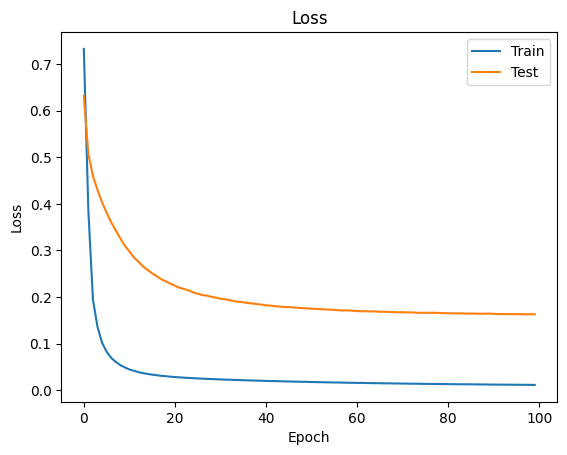

In [67]:
plt.plot(history_cf.history['loss'])
plt.plot(history_cf.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

##  Neural Collaborative Filtering

In [68]:
users_in = layers.Input(name="cf_users_in", shape=(1,))
cf_users_emb = layers.Embedding(name="cf_users_emb", input_dim=num_users, output_dim=embeddings_size)(users_in)
cf_users = layers.Reshape(name='cf_users', target_shape=(embeddings_size,))(cf_users_emb)

books_in = layers.Input(name="cf_books_in", shape=(1,))
cf_books_emb = layers.Embedding(name="cf_books_emb", input_dim=num_books, output_dim=embeddings_size)(books_in)
cf_books = layers.Reshape(name='cf_books', target_shape=(embeddings_size,))(cf_books_emb)

cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_users, cf_books])

nn_users_emb = layers.Embedding(name="nn_users_emb", input_dim=num_users, output_dim=embeddings_size)(users_in)
nn_users = layers.Reshape(name='nn_users', target_shape=(embeddings_size,))(nn_users_emb)

nn_books_emb = layers.Embedding(name="nn_books_emb", input_dim=num_books, output_dim=embeddings_size)(books_in)
nn_books = layers.Reshape(name='nn_books', target_shape=(embeddings_size,))(nn_books_emb)

nn_xx = layers.Concatenate()([nn_users, nn_books])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

y_out = layers.Concatenate()([cf_xx, nn_xx])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

model_ncf = models.Model(inputs=[users_in, books_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model_ncf.compile(optimizer='adam', loss='mean_absolute_error')
model_ncf.summary()

Model: "Neural_CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 cf_users_in (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 cf_books_in (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 nn_users_emb (Embedding)    (None, 1, 30)                676170    ['cf_users_in[0][0]']         
                                                                                                  
 nn_books_emb (Embedding)    (None, 1, 30)                219540    ['cf_books_in[0][0]']         
                                                                      

In [69]:
history_ncf = model_ncf.fit(
    x=[train["User-ID"], train["ISBN"]], y=train["rating"], 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    verbose=1, 
    validation_split=0.3
)

Epoch 1/100
155/155 [==============================] - 2s 7ms/step - loss: 0.3249 - val_loss: 0.2042
Epoch 2/100
155/155 [==============================] - 1s 7ms/step - loss: 0.1105 - val_loss: 0.1720
Epoch 3/100
155/155 [==============================] - 1s 7ms/step - loss: 0.0827 - val_loss: 0.1690
Epoch 4/100
155/155 [==============================] - 1s 7ms/step - loss: 0.0662 - val_loss: 0.1633
Epoch 5/100
155/155 [==============================] - 1s 7ms/step - loss: 0.0546 - val_loss: 0.1611
Epoch 6/100
155/155 [==============================] - 1s 7ms/step - loss: 0.0474 - val_loss: 0.1588
Epoch 7/100
155/155 [==============================] - 1s 7ms/step - loss: 0.0420 - val_loss: 0.1562
Epoch 8/100
155/155 [==============================] - 1s 7ms/step - loss: 0.0383 - val_loss: 0.1580
Epoch 9/100
155/155 [==============================] - 1s 7ms/step - loss: 0.0350 - val_loss: 0.1563
Epoch 10/100
155/155 [==============================] - 1s 7ms/step - loss: 0.0325 - val_lo

In [70]:
test["predicted"] = history_ncf.model.predict([test["User-ID"], test["ISBN"]])
test

63/63 [==============================] - 0s 573us/step


,User-ID,ISBN,rating,predicted
0,13,5861,0.500000,0.763788
1,13,5862,0.500000,0.890400
2,13,5863,0.833333,0.804203
3,13,5864,0.500000,0.795085
4,13,5865,0.500000,0.810010
...,...,...,...,...
2005,22534,7297,0.500000,0.735893
2006,22535,7304,0.500000,0.720487
2007,22536,7305,0.500000,0.746475
2008,22537,7306,0.500000,0.834463


In [71]:
y_test = test["rating"]
predicted = test["predicted"]

print("Mean Absolute Percent Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Percent Error (Σ(|y-pred|/y)/n): 0.33%


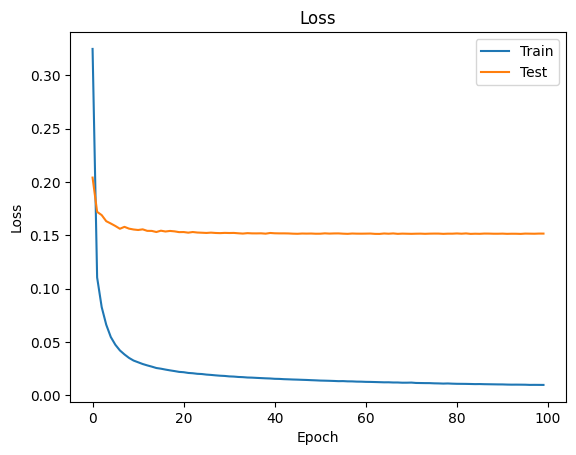

In [72]:
plt.plot(history_ncf.history['loss'])
plt.plot(history_ncf.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

## Extra Feature Model

Let's add genre data:

In [73]:
train = train.merge(df[genres], how="left", left_on="ISBN", right_index=True)
train

,User-ID,ISBN,rating,Fiction,Novels,Adult,Mystery,Contemporary,Thriller,Romance,...,Historical Fiction,Adult Fiction,Literature,Mystery Thriller,Crime,Audiobook,Historical,Adventure,Science Fiction,Young Adult
0,0,0,0.900000,1,1,1,0,1,0,0,...,1,1,0,0,0,0,1,0,0,0
1,0,1,1.000000,1,1,1,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
2,0,2,0.800000,1,1,0,0,0,0,1,...,1,0,1,0,0,0,1,0,0,0
3,1,0,0.700000,1,1,1,0,1,0,0,...,1,1,0,0,0,0,1,0,0,0
4,1,217,0.928571,1,1,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56522,22022,5850,0.833333,1,1,0,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
56523,22023,5851,1.000000,1,1,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
56524,22024,5852,1.000000,1,1,1,1,1,0,0,...,0,1,1,0,0,0,0,0,0,0
56525,22025,5853,0.700000,1,1,1,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0


In [74]:
test = test.merge(df[genres], how="left", left_on="ISBN", right_index=True)
test

,User-ID,ISBN,rating,predicted,Fiction,Novels,Adult,Mystery,Contemporary,Thriller,...,Historical Fiction,Adult Fiction,Literature,Mystery Thriller,Crime,Audiobook,Historical,Adventure,Science Fiction,Young Adult
0,13,5861,0.500000,0.763788,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,13,5862,0.500000,0.890400,1,1,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2,13,5863,0.833333,0.804203,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,13,5864,0.500000,0.795085,1,1,1,1,0,1,...,1,0,0,1,1,0,1,1,0,0
4,13,5865,0.500000,0.810010,1,1,1,1,0,1,...,1,0,0,1,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,22534,7297,0.500000,0.735893,1,1,1,1,0,1,...,1,0,0,1,1,0,1,1,0,0
2006,22535,7304,0.500000,0.720487,1,1,1,0,1,0,...,0,1,1,0,0,0,0,0,0,0
2007,22536,7305,0.500000,0.746475,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2008,22537,7306,0.500000,0.834463,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [75]:
users_in = layers.Input(name="cf_users_in", shape=(1,))
cf_users_emb = layers.Embedding(name="cf_users_emb", input_dim=num_users, output_dim=embeddings_size)(users_in)
cf_users = layers.Reshape(name='cf_users', target_shape=(embeddings_size,))(cf_users_emb)

books_in = layers.Input(name="books_in", shape=(1,))
cf_books_emb = layers.Embedding(name="cf_books_emb", input_dim=num_books, output_dim=embeddings_size)(books_in)
cf_books = layers.Reshape(name='cf_books', target_shape=(embeddings_size,))(cf_books_emb)

cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_users, cf_books])

nn_users_emb = layers.Embedding(name="nn_users_emb", input_dim=num_users, output_dim=embeddings_size)(users_in)
nn_users = layers.Reshape(name='nn_users', target_shape=(embeddings_size,))(nn_users_emb)

nn_books_emb = layers.Embedding(name="nn_books_emb", input_dim=num_books, output_dim=embeddings_size)(books_in)
nn_books = layers.Reshape(name='nn_books', target_shape=(embeddings_size,))(nn_books_emb)

nn_xx = layers.Concatenate()([nn_users, nn_books])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

genres_in = layers.Input(name="genres_in", shape=(len(genres),))
genres_x = layers.Dense(name="features_x", units=len(genres), activation='relu')(genres_in)

y_out = layers.Concatenate()([cf_xx, nn_xx, genres_x])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

model_comb = models.Model(inputs=[users_in, books_in, genres_in], outputs=y_out, name="Hybrid_Model")
model_comb.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model_comb.summary()

Model: "Hybrid_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 cf_users_in (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 books_in (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 nn_users_emb (Embedding)    (None, 1, 30)                676170    ['cf_users_in[0][0]']         
                                                                                                  
 nn_books_emb (Embedding)    (None, 1, 30)                219540    ['books_in[0][0]']            
                                                                                       

In [76]:
history_comb = model_comb.fit(
    x=[train["User-ID"], train["ISBN"], train[genres]], y=train["rating"], 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    verbose=1, 
    validation_split=0.3
)

Epoch 1/100
155/155 [==============================] - 2s 9ms/step - loss: 0.2612 - mean_absolute_percentage_error: 34.0085 - val_loss: 0.1616 - val_mean_absolute_percentage_error: 23.0205
Epoch 2/100
155/155 [==============================] - 1s 9ms/step - loss: 0.1101 - mean_absolute_percentage_error: 15.4449 - val_loss: 0.1570 - val_mean_absolute_percentage_error: 22.2033
Epoch 3/100
155/155 [==============================] - 1s 9ms/step - loss: 0.0810 - mean_absolute_percentage_error: 11.2618 - val_loss: 0.1549 - val_mean_absolute_percentage_error: 22.3422
Epoch 4/100
155/155 [==============================] - 1s 9ms/step - loss: 0.0642 - mean_absolute_percentage_error: 8.8335 - val_loss: 0.1549 - val_mean_absolute_percentage_error: 22.0409
Epoch 5/100
155/155 [==============================] - 1s 9ms/step - loss: 0.0531 - mean_absolute_percentage_error: 7.2580 - val_loss: 0.1547 - val_mean_absolute_percentage_error: 21.9957
Epoch 6/100
155/155 [==============================] - 1s

In [77]:
test["predicted"] = history_comb.model.predict([test["User-ID"], test["ISBN"], test[genres]])
test

63/63 [==============================] - 0s 597us/step


,User-ID,ISBN,rating,predicted,Fiction,Novels,Adult,Mystery,Contemporary,Thriller,...,Historical Fiction,Adult Fiction,Literature,Mystery Thriller,Crime,Audiobook,Historical,Adventure,Science Fiction,Young Adult
0,13,5861,0.500000,0.791523,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,13,5862,0.500000,0.897707,1,1,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2,13,5863,0.833333,0.728099,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,13,5864,0.500000,0.875659,1,1,1,1,0,1,...,1,0,0,1,1,0,1,1,0,0
4,13,5865,0.500000,0.810894,1,1,1,1,0,1,...,1,0,0,1,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,22534,7297,0.500000,0.798113,1,1,1,1,0,1,...,1,0,0,1,1,0,1,1,0,0
2006,22535,7304,0.500000,0.884303,1,1,1,0,1,0,...,0,1,1,0,0,0,0,0,0,0
2007,22536,7305,0.500000,0.884269,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2008,22537,7306,0.500000,0.843085,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [78]:
y_test = test["rating"]
predicted = test["predicted"]

print("Mean Absolute Percent Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test - predicted)/predicted)), 2))+"%")

Mean Absolute Percent Error (Σ(|y-pred|/y)/n): 0.33%


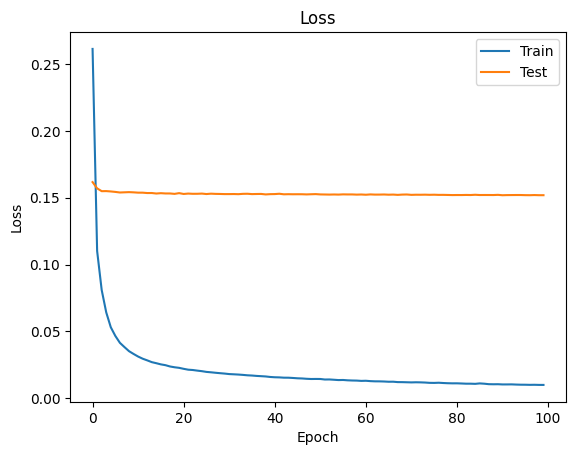

In [79]:
plt.plot(history_comb.history['loss'])
plt.plot(history_comb.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

**Collaborative Filtering experiments conclusion**: The collaborative filtering model does not work well on this dataset. This can be a result of the little review per user count (≈ 3).